In [1]:
import numpy as np
import pyopencl as cl
from PIL import Image
from IPython.display import display, clear_output
import signal

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch import Tensor
from torch.autograd import Variable
import torchvision.transforms as T

In [4]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (20.0, 8.0)
plt.rcParams['image.interpolation'] = 'bilinear'
plt.rcParams['image.cmap'] = 'hot'

In [5]:
from util import *
from clutil import *
from compute import *
from generate import *

%load_ext autoreload
%autoreload 2

In [6]:
import signal

signal_done = False

def signal_handler(signal, frame):
    global signal_done
    signal_done = True

def stop_on_signal():
    global signal_done
    signal_done = False
    signal.signal(signal.SIGINT, signal_handler)

In [7]:
ctx = cl.create_some_context()

In [29]:
def augment_data(images, size):
    # random crop
    vx, vy = images.shape[-1]-size[0], images.shape[-2]-size[1]
    x, y = np.random.randint(0, vx), np.random.randint(0, vy)
    images = images[:,:,y:y+size[1],x:x+size[0]]
    # random flip (need to flip speed dir)
    #fx, fy = [np.random.choice([-1, 1]) for _ in range(2)]
    #images = images[:][:][::fy][::fx]
    return images

In [14]:
torch.cuda.is_available()

True

In [15]:
class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size()
        return x.view(N, -1)

In [16]:
class Discriminator(nn.Module):
    def __init__(self, conv, fc, ksize=3):
        super().__init__()
        
        self.kernel_size = ksize
        pad = (ksize - 1)//2;
        
        levels = []
        for level in conv:
            layers = []
            for conv_in, conv_out in zip(level[:-1], level[1:]):
                layers.extend([
                    nn.Conv2d(conv_in, conv_out, kernel_size=ksize, padding=pad),
                    nn.ReLU(),
                ])
            layers.append(nn.MaxPool2d(2, stride=2))
            levels.append(nn.ModuleList(layers))
        self.conv = nn.ModuleList(levels)
        
        layers = [Flatten()]
        for fc_in, fc_out in zip(fc[:-1], fc[1:]):
            layers.extend([
                nn.Linear(fc_in, fc_out),
                nn.ReLU(),
            ])
        layers.pop()
        self.fc = nn.ModuleList(layers)
    
    def forward(self, x):
        for d in self.conv:
            for l in d:
                #print(x.shape)
                x = l(x)
            
        for l in self.fc:
            x = l(x)

        return x

In [17]:
class Reshape(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape
        
    def forward(self, x):
        N, X = x.size()
        return x.view(N, *self.shape)

In [104]:
class Generator(nn.Module):
    def __init__(self, fc, shape, upconv, ksize=3):
        super().__init__()
        
        self.kernel_size = ksize
        pad = (ksize - 1)//2;
        
        layers = []
        for fc_in, fc_out in zip(fc[:-1], fc[1:]):
            layers.extend([
                nn.Linear(fc_in, fc_out),
                nn.ReLU(),
            ])
        layers.append(Reshape(shape))
        self.fc = nn.ModuleList(layers)
        last_size = shape[0]
        
        levels = []
        for level in upconv:
            layers = []
            layers.append(nn.ConvTranspose2d(last_size, level[0], kernel_size=2, stride=2))
            for conv_in, conv_out in zip(level[:-1], level[1:]):
                layers.extend([
                    nn.ConvTranspose2d(conv_in, conv_out, kernel_size=ksize, padding=pad),
                    nn.ReLU(),
                ])
            layers.pop()
            levels.append(nn.ModuleList(layers))
            last_size = level[-1]
        self.upconv = nn.ModuleList(levels)
    
    def forward(self, x):
        for l in self.fc:
            x = l(x)
        
        for u in self.upconv:
            for l in u:
                x = l(x)
        
        return x

In [105]:
def train_discriminator(g_model, d_model, d_optim, loss_fn, real_images, g_input):
    g_model.train()
    d_model.train()
    
    g_input_var = Variable(Tensor(g_input).cuda())
    
    fake_images_var = g_model(g_input_var).detach() # do not train g_model
    
    real_images_var = Variable(Tensor(real_images).cuda())
    
    real_labels_var = Variable(Tensor(np.ones(real_images.shape[0])).cuda().long())
    fake_labels_var = Variable(Tensor(np.zeros(g_input.shape[0])).cuda().long())
    
    d_optim.zero_grad()

    pred_labels_var = d_model(real_images_var)
    real_loss = loss_fn(pred_labels_var, real_labels_var)
    real_loss.backward()
    
    pred_labels_var = d_model(fake_images_var)
    fake_loss = loss_fn(pred_labels_var, fake_labels_var)
    fake_loss.backward()

    d_optim.step()
    
    return real_loss.data[0], fake_loss.data[0]

In [106]:
def train_generator(g_model, d_model, g_optim, loss_fn, g_input):
    g_model.train()
    d_model.train()
    
    g_input_var = Variable(Tensor(g_input).cuda())
    real_labels_var = Variable(Tensor(np.ones(g_input.shape[0])).cuda().long())
    
    g_optim.zero_grad()
    
    fake_images_var = g_model(g_input_var)

    pred_labels_var = d_model(fake_images_var)
    loss = loss_fn(pred_labels_var, real_labels_var)
    loss.backward()
    
    g_optim.step() # do not train d_model
    
    return loss.data[0]

In [107]:
def apply_generator(model, x):
    model.eval()
    x_var = Variable(Tensor(x).cuda(), volatile=True)
    y_pred = model(x_var)
    return y_pred.data.cpu().numpy()

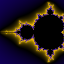

In [132]:
train_scene = Scene(ctx, (128, 128), scale=2)
train_scene.compute((-0.8, 0), (2.4, 0), max_depth=1024)
display_image(train_scene.colorize([[0,0,0,1], [1,0.8,0,1], [0.2,0,1,1]], period=20))

In [133]:
branch = [64]
zoom = 2
image_params = {
    "color_map": [[0,0,0,1],[1,0.8,0,1],[0.2,0,1,1]],
    "period": 40,
    "inner_color": [0,0,0,1],
}

In [140]:
g_dim = 3
g_model = Generator(
    fc=(g_dim, 16, 1024),
    shape=(16, 8, 8),
    upconv=(
        (16, 12),
        (12, 8),
        (8, 8, 3),
    ),
    ksize=3,
).cuda()

In [141]:
d_model = Discriminator(
    conv=(
        (3, 8, 8),
        (8, 12),
        (12, 16),
    ),
    fc=(1024, 16, 2),
    ksize=3,
).cuda()

In [142]:
loss_fn = nn.CrossEntropyLoss().cuda()
g_optim = optim.Adam(g_model.parameters(), lr=1e-4, weight_decay=1e-7)
d_optim = optim.Adam(d_model.parameters(), lr=1e-4, weight_decay=1e-7)

In [143]:
step = 0
losses = np.array([0.0, 0.0, 0.0], dtype=np.float32)
loss_history = np.array([[],[],[]], dtype=np.float32)
steps = []
noise = lambda size: np.random.randn(size,g_dim)

In [144]:
g_freq, d_freq = 1, 1

30900: {g: 10.45239, dr: 4.6537258e-07, df: 2.8911327e-05}


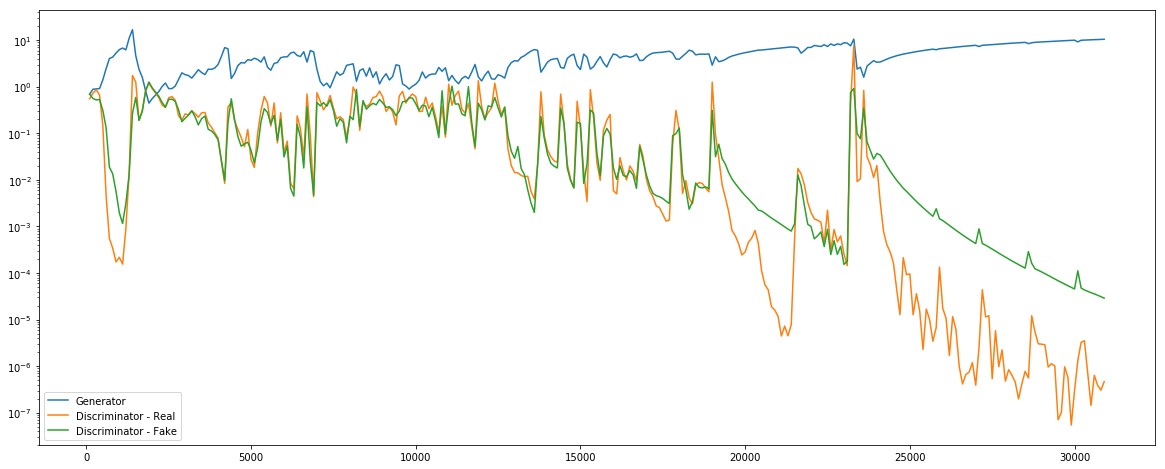

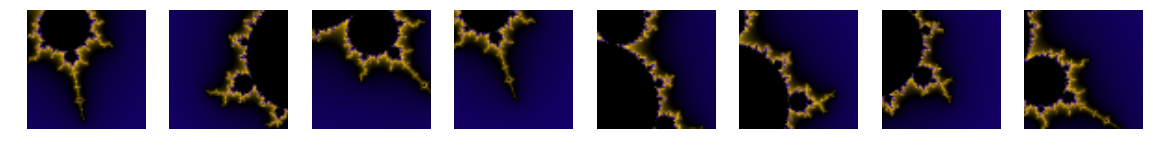

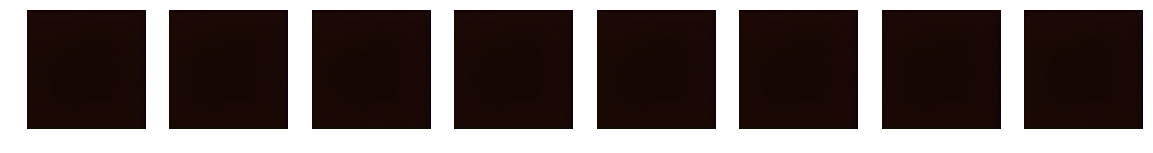

In [145]:
print_every = 100
stop_on_signal()
while not signal_done:
    for i in range(d_freq):
        real_images = generate(train_scene, branch, zoom, params=image_params)[0]
        real_images = real_images[:,:,:,:3].transpose(0,3,1,2)
        losses[1:] += train_discriminator(g_model, d_model, d_optim, loss_fn, real_images, noise(np.prod(branch)))
    losses[1:] /= d_freq
    for i in range(g_freq):
        losses[0] += train_generator(g_model, d_model, g_optim, loss_fn, noise(np.prod(branch)))
    losses[0] /= g_freq
    
    if (step+1) % print_every == 0:
        clear_output()
        losses /= print_every
        print("%s: {g: %s, dr: %s, df: %s}" % (step+1, *losses))
        steps.append(step+1)
        loss_history = np.append(loss_history, losses.reshape(-1, 1), axis=1)
        losses.fill(0.0)
        
        plt.plot(steps, loss_history[0], label="Generator")
        plt.plot(steps, loss_history[1], label="Discriminator - Real")
        plt.plot(steps, loss_history[2], label="Discriminator - Fake")
        plt.yscale('log')
        plt.legend()
        plt.show()
        
        plot_images(real_images[:8].transpose(0,2,3,1))
        plot_images(apply_generator(g_model, noise(8)).transpose(0,2,3,1))
        
    step += 1